In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Provides a way to split the data into train and test data sets.
from sklearn.model_selection import train_test_split 

#Implements the KNN algorithm
from sklearn.neighbors import KNeighborsClassifier

#Provides a way to calculate metrics on the model
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve,  roc_auc_score

#Used to manipulate column names
import re

In [2]:
df = pd.read_csv('adult_census/adult.data', header=None)

In [3]:
len(df)

32561

In [4]:
pattern="[a-z_]+:"
file = open('adult_census/adult.names', mode='r')
data = file.read()
file.close()
matches = re.findall(pattern, data)

In [5]:
matches[9:23]

['age:',
 'workclass:',
 'fnlwgt:',
 'education:',
 'education_num:',
 'marital_status:',
 'occupation:',
 'relationship:',
 'race:',
 'sex:',
 'capital_gain:',
 'capital_loss:',
 'hours_per_week:',
 'native_country:']

In [6]:
colnames = list()

In [7]:
for match in matches[9:23]:
    colnames.append(match[:-1])

In [8]:
colnames.append('salary')

In [9]:
colnames

['age',
 'workclass',
 'fnlwgt',
 'education',
 'education_num',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'native_country',
 'salary']

In [10]:
df.columns = colnames

In [11]:
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Recode salary value

In [12]:
df.salary.groupby(df.salary).count()

salary
 <=50K    24720
 >50K      7841
Name: salary, dtype: int64

There are leading spaces in the data, let's remove them.

In [13]:
df.salary = df.salary.str.strip()

In [24]:
df.to_csv('adult_census/original_census.csv', index=False)

In [14]:
df['salary'].replace("<=50K", 0, inplace=True)
df['salary'].replace(">50K", 1, inplace=True)

In [16]:
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Process workclass variable - I used this to figure what I needed to do for columns to be standardized.

In [17]:
df.workclass = df.workclass.str.strip()
df.workclass = df.workclass.str.replace("-", "_")
df.workclass = df.workclass.str.lower()
df.workclass.replace("?", "unknown", inplace=True)

In [18]:
df.workclass.groupby(df.workclass).count()

workclass
federal_gov           960
local_gov            2093
never_worked            7
private             22696
self_emp_inc         1116
self_emp_not_inc     2541
state_gov            1298
unknown              1836
without_pay            14
Name: workclass, dtype: int64

Function to prepare columns with string-based categorical data.

In [19]:
def prep_column(col):
    col = col.str.strip()
    col = col.str.replace("-", "_")
    col = col.str.lower()
    col.replace("?", "unknown", inplace=True)
    return col

In [19]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'salary'],
      dtype='object')

Prep each relevant column

In [20]:
df.education = prep_column(df.education)
df.marital_status = prep_column(df.marital_status)
df.occupation = prep_column(df.occupation)
df.relationship = prep_column(df.relationship)
df.race = prep_column(df.race)
df.sex = prep_column(df.sex)
df.native_country = prep_column(df.native_country)

In [21]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country',
       'salary'],
      dtype='object')

The **education_num** shows the same data as education. I am going to drop and one-hot encode education.

In [22]:
df.drop('education_num', axis=1, inplace=True)

In [23]:
df.head()

,age,workclass,fnlwgt,education,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,39,state_gov,77516,bachelors,never_married,adm_clerical,not_in_family,white,male,2174,0,40,united_states,<=50K
1,50,self_emp_not_inc,83311,bachelors,married_civ_spouse,exec_managerial,husband,white,male,0,0,13,united_states,<=50K
2,38,private,215646,hs_grad,divorced,handlers_cleaners,not_in_family,white,male,0,0,40,united_states,<=50K
3,53,private,234721,11th,married_civ_spouse,handlers_cleaners,husband,black,male,0,0,40,united_states,<=50K
4,28,private,338409,bachelors,married_civ_spouse,prof_specialty,wife,black,female,0,0,40,cuba,<=50K


In [24]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

Function to apply to each column that has categorical data so they can be one-hot encoded.

In [25]:
def one_hot_encode(col):
    col_array = np.array(col)
    col_array = col_array.reshape(-1,1)
    col_array = enc.fit_transform(col_array).toarray()
    new_df = pd.DataFrame(col_array, columns=list(enc.categories_))
    new_df.columns = new_df.columns.get_level_values(0)
    return new_df
    

### Columns to encode

In [26]:
df_workclass = one_hot_encode(df.workclass)
df_education = one_hot_encode(df.education)
df_marital_status = one_hot_encode(df.marital_status)
df_occupation = one_hot_encode(df.occupation)
df_relationship = one_hot_encode(df.relationship)
df_race = one_hot_encode(df.race)
df_sex = one_hot_encode(df.sex)
df_native_country = one_hot_encode(df.native_country)

Drop the original columns from the data set, we'll add them back as one-hot encoded.

In [27]:
df.drop(['workclass', 'education', 'marital_status', 
          'occupation', 'relationship', 'race', 'sex',
          'native_country'], axis=1, inplace=True)

Save non-categorical columns to a file. Might do an analysis on this.

In [28]:
df.to_csv('adult_census/short_census.csv', index=False)

Put salary into outcome array

In [29]:
y = df['salary']

In [30]:
df.drop(['salary'], axis=1, inplace=True)

In [31]:
X = pd.concat([df, df_workclass, df_education, df_marital_status,
                      df_occupation, df_relationship, df_race,
                      df_sex, df_native_country], axis=1)

In [39]:
final_df = pd.concat([X, y], axis=1)

In [41]:
final_df.to_csv('adult_census/final_data_set.csv', index=None)

In [42]:
pd.set_option('display.max_columns', None)

Set up training/testing sets.

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.20, random_state=32)

Fit the model

In [60]:
neigh = KNeighborsClassifier(n_neighbors=15)
neigh.fit(X_train,y_train)
y_pred = neigh.predict(X_test)

In [61]:
accuracy_score(y_pred, y_test)*100

80.63872255489022

Text(0.5, 24.0, 'Predicted Label')

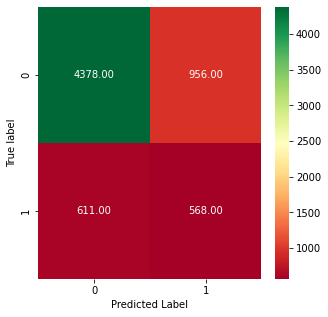

In [ ]:
cm = confusion_matrix(y_pred, y_test)
fig = plt.figure(figsize=(5,5))
heatmap = sns.heatmap(cm, annot=True, fmt='.2f', cmap='RdYlGn')
plt.ylabel('True label')
plt.xlabel('Predicted Label')

In [38]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.95      0.81      0.87      5836
           1       0.28      0.62      0.38       677

    accuracy                           0.79      6513
   macro avg       0.61      0.72      0.63      6513
weighted avg       0.88      0.79      0.82      6513



In [64]:
ns_probs = [0 for _ in range(len(y_test))]

In [78]:
lr_probs = neigh.predict_proba(X_test)
lr_probs = lr_probs[:,1]

In [79]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)

In [93]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

In [107]:
lr_tpr=lr_tpr.reshape(-1,1)
lr_fbr = lr_fpr.reshape(-1,1)

(-0.1, 1.0)

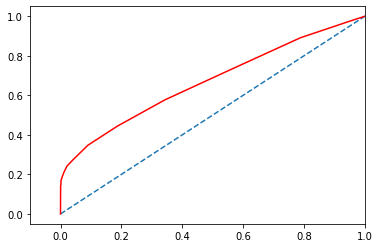

In [118]:
plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(lr_fbr, lr_tpr, color='red')
plt.xlim([-0.1,1])

In [114]:
roc_auc_score(y_test, lr_probs)

0.669979795444992